![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.colors as colors

# Détection d'anomalies

## Mise en situation
Je travaille pour une banque. Je dispose des données de transactions bancaires par client, et j'aimerais détecter une utilisation suspecte - une anomalie.

Je ne sais pas à quoi ça peut ressembler une anomalie : je ne peux pas vraiment faire de classification supervisée. Et puis quand bien même : un nouveau type de fraude pourrait apparaitre, que je ne saurais pas reconnaitre...

## Détection d'anomalies par analyse des distributions gaussiennes
Il existe plusieurs classes d'algorithmes pour la détection d'anomalies. Celle présentée ici n'est pas la meilleure mais c'est probablement la plus simple à comprendre / appliquer.

Accessoirement, elle n'est pas mauvaise non plus...

### Distribution gaussienne ?
Une variable aléatoire $X$ est gaussienne (ou normale) lorsqu'elle suit une _loi normale_, dont la densité de probabilité est :

$f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

avec $\mu$ la moyenne des valeurs de cette variable, et $\sigma$ l'écart-type. On note la distribution $\mathcal{N}(\mu, \sigma^2)$, le carré de l'écart type étant la _variance_.

Comme je suis lucide, je me doute que c'est par forcément plus clair pour autant, alors un peu de visuel ne fera pas de mal : voici quelques courbes représentatives de $f$ pour différentes valeurs de $\mu$ et de $\sigma$

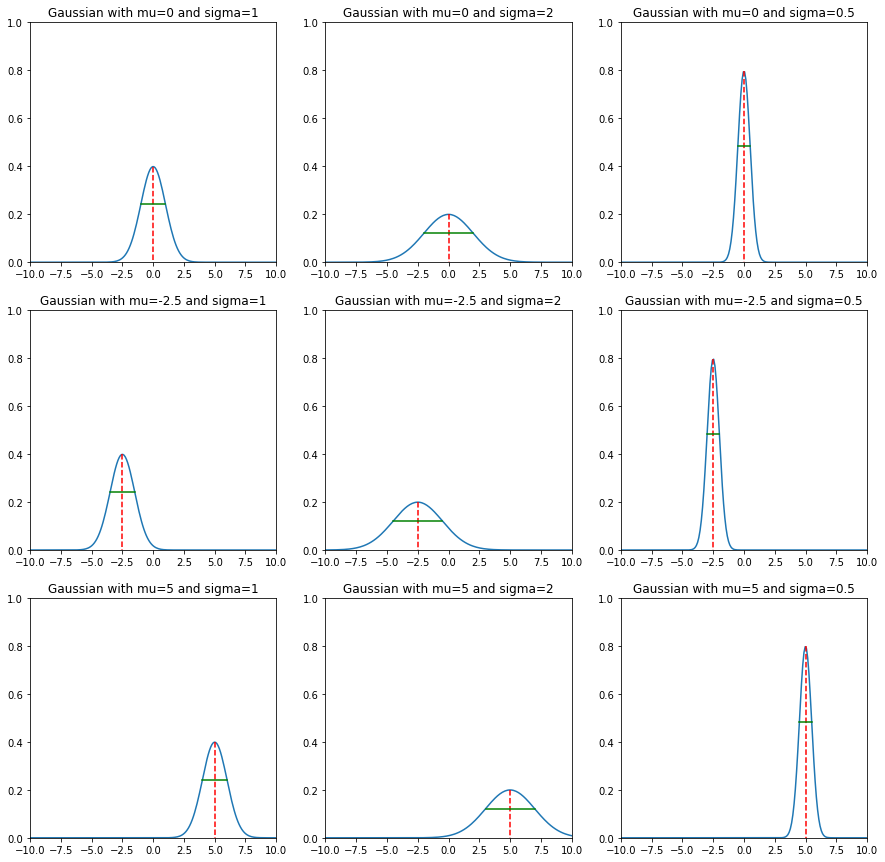

In [2]:
def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))

i=0
fig=plot.figure(figsize=(15,15))
for mu in [0, -2.5, 5]:
    for sigma in [1, 2, 0.5]:
        i+=1
        x = np.linspace(-10, 10, 200)
        y = gaussian(x , mu, sigma)
        fig.add_subplot(3,3,i)
        plot.xlim(-10, 10)
        plot.ylim(0, 1)
        plot.plot(x, y)
        plot.plot([mu,mu], [gaussian(mu, mu, sigma), 0], "r--")
        plot.plot([mu-sigma, mu+sigma], [gaussian(mu-sigma, mu, sigma), gaussian(mu+sigma, mu, sigma)], "g-")
        plot.title('Gaussian with mu=%s and sigma=%s' % (str(mu), str(sigma)))

La valeur de $\mu$ est la valeur de $x$ qui maximise la fonction (le progeté en rouge pointillé).

La valeur de $\sigma$ correspond à la largeur de la cloche.
* A une hauteur de 60% environ de la courbe, on retrouve une largeur de $2\sigma$ (plus exactement à $\frac{1}{\sqrt{e}}$ qui vaut environ 0.606)
* On parle parfois de _Largeur à mi hauteur_ (LMH, ou _Full width at half maximum_, FWHM en anglais) : à 50% de la hauteur, la largeur est de $2.35\sigma$

La surface sous la courbe vaut 1, quoi qu'il arrive : 
* l'intégrale de Gauss est connue : $\int_{-\infty}^{\infty}{e^{-\frac{x^2}{\alpha}}dx} = \sqrt{\frac{\pi}{\alpha}}$
* avec $\alpha = \frac{1}{2\sigma^2}$, on trouve $\sigma\sqrt{2\pi}$
* Et on divise le tout par cette même quantité : total = 1

Sur un intervalle plus restreint : la probabilité pour une variable aléatoire de se trouver entre $a$ et $b$ est égale à $\int_{a}^{b}f_{\mu, \sigma}(t).dt$

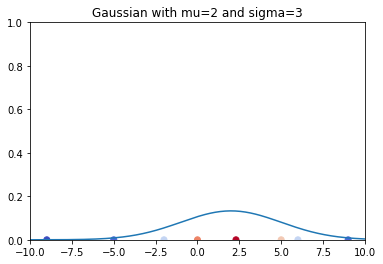

In [3]:
mu = 2
sigma = 3
x = np.linspace(-10, 10, 200)
y = gaussian(x , mu, sigma)
plot.xlim(-10, 10)
plot.ylim(0, 1)
plot.plot(x, y)
plot.title('Gaussian with mu=%s and sigma=%s' % (str(mu), str(sigma)))

x_range = np.array([-9, -5, -2, 0, 2.3, 5, 6, 9])
plot.scatter(x_range, np.zeros(x_range.shape), c = gaussian(x_range, mu, sigma), cmap=plot.cm.coolwarm)

plot.show()

On peut voir sur cette figure que la probabilité d'avoir une valeur de 0 est plus élevée que d'avoir une valeur de -5, mais moins que d'avoir 2.3.

Pour être tout à fait exact, la probabilité d'avoir exactement 0 est nulle, comme toute probabilité d'avoir une valeur exacte sur ce genre de distributions. Mais la probabilité d'avoir une valeur dans un rayon $\epsilon$ autour de 0 est plus importante que pour le même rayon autor de -5 mais moins que pour 2.3.

### Détection d'anomalies à une dimension
L'algorithme dans une version à une seule dimension est assez simple à appréhender.

Considérons un ensemble de $m$ valeurs "conformes" : on établit à partir de cette liste une distribution normale.
* $\mu = \frac{\sum{x}}{m}$ la moyenne des valeurs
* $\sigma = \sqrt{\frac{\sum{(x-\mu)^2}}{m}}$ l'écart type

Pour toute nouvelle valeur $x$, on considérera qu'elle est une anomalie si $f_{\mu, \sigma}(x) \lt \epsilon$, avec $\epsilon$ une constante, très petite, à définir.

Exemple :

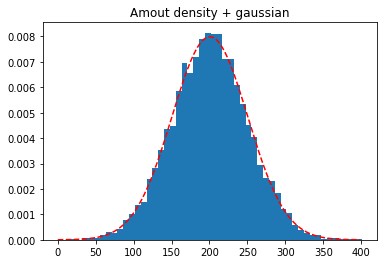

An amount of $-80 is detected as an anomaly
An amount of $5 is not detected as an anomaly
An amount of $20 is not detected as an anomaly
An amount of $50 is not detected as an anomaly
An amount of $200 is not detected as an anomaly
An amount of $400 is not detected as an anomaly
An amount of $800 is detected as an anomaly
An amount of $1000 is detected as an anomaly


In [4]:
np.random.seed(1)

# On dispose des montants des transactions passées
amount = np.random.normal(200, 50, 10000).reshape(10000, 1)

mu = np.mean(amount)
sigma = np.std(amount)
def anomaly_1D(x, mu, sigma, epsilon):
    gaussian_value = gaussian(x, mu, sigma)
    return gaussian_value < epsilon

#Densité, et gaussienne associée - mu et sigma statistiquement déterminés
plot.hist(amount, 50, density=True)
plot.plot(np.arange(400), gaussian(np.arange(400), mu, sigma), "r--")
plot.title('Amout density + gaussian')
plot.show()

test_set = np.array([-80, 5, 20, 50, 200, 400, 800, 1000])
epsilon = 1e-7
anomalies = anomaly_1D(test_set, mu, sigma, epsilon)

for i in range(len(test_set)):
    print('An amount of $%i %s detected as an anomaly' % (test_set[i], 'is' if anomalies[i] else 'is not'))

Bien entendu, en augmentant $\epsilon$, on baisse le seuil à partir duquel une donnée est anormale. En gros, vu comme ça, c'est équivalent à 
> "$x$ est une anomalie si $x \gt X_\epsilon$ ou si $x \lt X'_\epsilon$"

avec $X_\epsilon, X'_\epsilon$ certaines valeurs de seuil. Ca a l'air un peu simpliste, mais c'est bien ça. On va passer en multi-dimensions, ça paraitra moins bête (même si le principe est identique).

### A propos de $\epsilon$ : la fine limite supervisé / non-supervisé
Cet algortihme rentre dans la catégorie des méthodes d'apprentissage non-supervisé : on ne sait pas ce qu'est une erreur dans ce modèle mais on va les trouver malgré tout.

Par contre, il est nécessaire d'avoir pour cela une valeur de seuil ($\epsilon$) et son choix est crucial : trop petit on incorpore des erreurs, trop grand on rejette des bonnes mesures... Du coup, _bien que le jeu de train ne nécessite pas de données "en erreur"_ on peut réaliser un apprentissage. Mais il est tout de même nécessaire d'en avoir quelques unes dans le jeu de données de dev pour calibrer correctement $\epsilon$...

### Note sur le caractère gaussien d'une variable
Pour que cette méthode fonctionne, il faut toutefois que la variable (ou les variables quand il y en a plusieurs) suivent une distribution normale, et c'est loin d'être systématiquement le cas...

Dans tous mes exemples ci-dessous notamment, on va tricher un peu mais c'est de la génération "gaussienne". On verra plus bas comment traiter du non-gaussien, ou essayer du moins.

### Détection d'anomalies sur plusieurs dimensions

Sur le principe, rien ne change : pour chaque dimension on va calculer la même quantité que précedemment. Seulement, au lieu de comparer chacune à un seuil, on va plutôt comparer leur produit à un seuil global.

> $\prod_{i=1}^n{f_{\mu_i, \sigma_i}(x)} \lt \epsilon_{global}$

Intuitivement : si une valeur est vraiment faible dans le lot, le produit va baisser et donc l'élément sera probablement une anomalie, à cause d'une de ses composantes "faible" par rapport à la distribution attendue.

In [5]:
def anomaly_nD (x, mus, sigmas, epsilon):
    gaussian_values = np.product(gaussian(x, mus, sigmas), axis = 1)
    return gaussian_values < epsilon

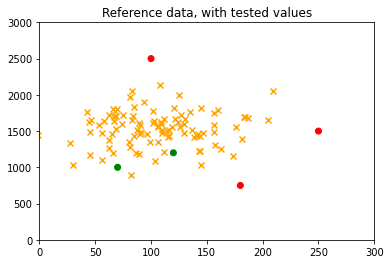

In [6]:
np.random.seed(1)

samples = 100
dim = 2
dataset = np.concatenate([
    np.random.normal(100, 50, samples).reshape(samples, 1),
    np.random.normal(1500, 250, samples).reshape(samples, 1)
    ], axis = 1)
mus = np.mean(dataset, axis = 0).reshape(1, -1)
sigmas = np.std(dataset, axis = 0).reshape(1, -1)

plot.xlim(0,300)
plot.ylim(0,3000)
plot.scatter(dataset[:,0], dataset[:,1], marker = "x",c='orange')
plot.title('Reference data, with tested values')

test_set = np.array([[70, 1000], [180, 750], [250, 1500], [100, 2500], [120,1200]])
epsilon = 1e-7
results = anomaly_nD(test_set, mus, sigmas, epsilon) 
plot.scatter(test_set[:,0], test_set[:,1], c=results, cmap=colors.ListedColormap(['green', 'red'], 'indexed'), marker = 'o')
plot.show()

### Problème des dimensions fortement corrélées
Jusqu'ici, le modèle n'a pas l'air trop mal. Cependant, lorsque les variables ne sont pas indépendantes, on peut avoir des soucis. Par exemple :

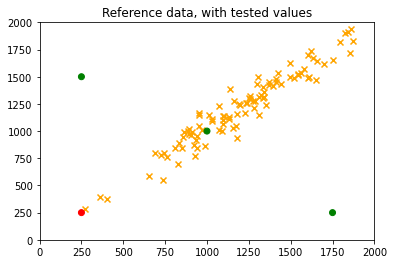

In [7]:
np.random.seed(1)

samples = 100
dataset = np.concatenate([
    np.random.normal(1000, 400, samples).reshape(samples, 1),
    np.random.normal(100, 50, samples).reshape(samples, 1)
],axis = 1)
dataset = np.concatenate([300 + dataset[:,:1] - dataset[:,1:], 100+dataset[:,:1] + dataset[:,1:]], axis = 1)

mus = np.mean(dataset, axis = 0).reshape(1, -1)
sigmas = np.std(dataset, axis = 0).reshape(1, -1)

plot.xlim(0,2000)
plot.ylim(0,2000)
plot.scatter(dataset[:,0], dataset[:,1], marker='x', color='orange')
plot.title('Reference data, with tested values')

test_set = np.array([[250,1500], [1750,250], [1000, 1000], [250,250]])
epsilon = 1e-9
results = anomaly_nD(test_set, mus, sigmas, epsilon) 
plot.scatter(test_set[:,0], test_set[:,1], c=results, cmap=colors.ListedColormap(['green', 'red'], 'indexed'), marker = 'o')
plot.show()

On voit bien sur le graphique que les deux mesures sont un peu dépendantes : quand l'une augmente, l'autre aussi.

Et on a clairement un souci : certains points sont verts, ils devraient être rouges, et le seul rouge devrait être vert. On a mis $\epsilon$ à un pour un milliard, augmenter cette valeur excluera les 2 mauvais points verts, mais va exclure encore plus fortement le mauvais point rouge. Inversement, baisser cette valeur passera tout en vert. 

Explication :

* sur la première dimension, on est entre 200 et 1200 à chaque fois : si on projette les données de référence sur l'axe des abscisses et les points testés, on est dans la bonne zone!
* sur la seconde dimension, en projettant sur l'axe des ordonnées, pareil.

Pour contourner ce problème, on peut utiliser une variante à base de matrice de covariance. Soit une matrice $X$, on note $\Sigma = X^T.X$ sa matrice de covariance.

La distribution gaussienne multivariée $\mathcal(\mu, \Sigma)$ répond à la fonction suivante, pas trop différente :

$f(x) = \frac{1}{\sqrt{(2\pi)^N |\Sigma|}} e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}$

avec :
* $\mu$ le vecteur des moyennes par dimension (dimension : n x 1)
* $\Sigma$ une matrice carrée, la matrice de covariance de nos données (dimension: n x n)
* $x$ la multivariable qu'on teste (dimension n x 1)
* $|M|$ le déterminant de la matrice $M$

Dans notre implémentation
* le dataset comporte un point par colonne, $\mu$ est calculé comme un vecteur ligne, les $x$ aussi : on permute les transpositions $\rightarrow(x-\mu)\Sigma^{-1}(x-\mu)^T$
* le résultat pour m tests simultanés est une matrice carrée au lieu d'un vecteur : on en prend la diagonale

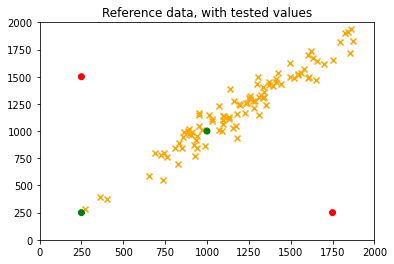

In [8]:
def anomaly_multi(x, mus, cov, epsilon):
    n = cov.shape[0]
    return np.diag(1/((2*np.pi)**(n/2)*np.linalg.det(cov)**(1/2)) * 
                   np.exp(-1/2 * np.dot(np.dot((x-mus), np.linalg.inv(cov)), (x-mus).T))) < epsilon

cov = np.dot((dataset-mus).T, (dataset-mus))

plot.xlim(0,2000)
plot.ylim(0,2000)
plot.scatter(dataset[:,0], dataset[:,1], marker='x', color='orange')
plot.title('Reference data, with tested values')

test_set = np.array([[250,1500], [1750,250], [1000, 1000], [250,250]])
epsilon = 3e-8
results = anomaly_multi(test_set, mus, cov, epsilon) 
plot.scatter(test_set[:,0], test_set[:,1], c=results, cmap=colors.ListedColormap(['green', 'red'], 'indexed'), marker = 'o')

plot.show()

### Cas de variables non gaussiennes
Parfois, les données ne suivent pas une loi normale. Il convient alors de voir si on peut les transformer un minimum pour obtenir quelque chose de plus gaussien. Exemple :

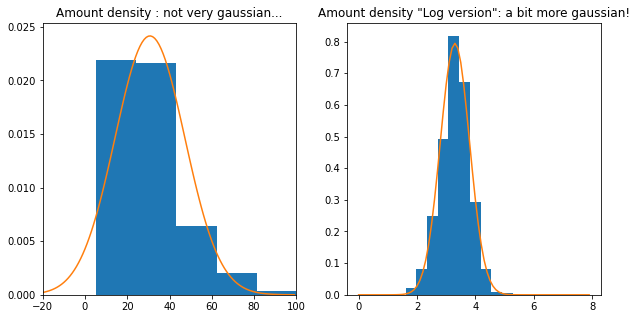

In [9]:
np.random.seed(1)

samples = 10000
amount = np.floor(np.exp(np.random.normal(1000,500,1000).reshape(-1,1)/1000)*10)

fig = plot.figure(figsize=(10, 5))
fig.add_subplot(121)
plot.xlim(-20, 100)
mu = np.mean(amount)
sigma = np.std(amount)
plot.hist(amount, density = True)
plot.plot(np.arange(-20, 100), gaussian(np.arange(-20, 100), mu, sigma))
plot.title('Amount density : not very gaussian...')

fig.add_subplot(122)
log_amount = np.log(amount)
log_mu = np.mean(log_amount)
log_sigma = np.std(log_amount)
plot.hist(log_amount, density = True)
plot.plot(np.arange(0, 8,0.1), gaussian(np.arange(0, 8,0.1), log_mu, log_sigma))
plot.title('Amount density "Log version": a bit more gaussian!')

plot.show()

Visualiser les histogrammes de densités peut aider à mieux y voir, et partir sur des mesures transformées peut améliorer leur caractère gaussien, et donc l'efficacité de la détection.

### Un autre type de souci
Quand les données sont un peu partitionnées, on peut aussi avoir des soucis :

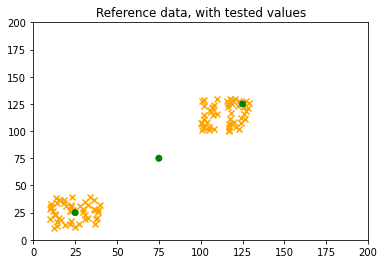

In [10]:
np.random.seed(1)

samples = 50
dataset = np.concatenate([np.random.rand(samples, 2)*30 + 10, np.random.rand(samples, 2)*30 + 100], axis = 0)

mus = np.mean(dataset, axis = 0).reshape(1, -1)
sigmas = np.std(dataset, axis = 0).reshape(1, -1)

plot.xlim(0,200)
plot.ylim(0,200)
plot.scatter(dataset[:,0], dataset[:,1], marker='x', color='orange')
plot.title('Reference data, with tested values')

test_set = np.array([[75, 75], [25, 25], [125, 125]])
epsilon = 1e-1
results = anomaly_nD(test_set, mus, sigmas, epsilon)
plot.scatter(test_set[:,0], test_set[:,1], c=results, cmap=colors.ListedColormap(['green', 'red'], 'indexed'), marker = 'o')

plot.show()

Là, c'est un autre genre de problème : le point au milieu sera difficilement détectable avec notre modèle. Pourtant $\epsilon$ est beaucoup plus élevé que d'habitude, on devrait avoir plus de rejet, mais on n'y arrivera pas point barre : autant sur les x que sur les y, le point est bien dans l'ensemble attendu :(

Pour résoudre ce problème, il faudra procéder différement. Par exemple : 
* dans un premier temps, classer les données en clusters (via les k-means)
* puis détecter l'anomalie sur chaque cluster (en fonction de ses propres $\mu$ et $\sigma$ ou $\Sigma$)
* Est une anomalie un point qui est détecté comme tel, sur chaque cluster.

## Retour à la mise en situation
### Chargement des données

Je dispose de 10.000 transactions passées avec les informations suivantes :
* montant de la transaction
* nombre de transactions précédentes sur 24 heures glissantes
* devise utilisée
* Heure de la journée

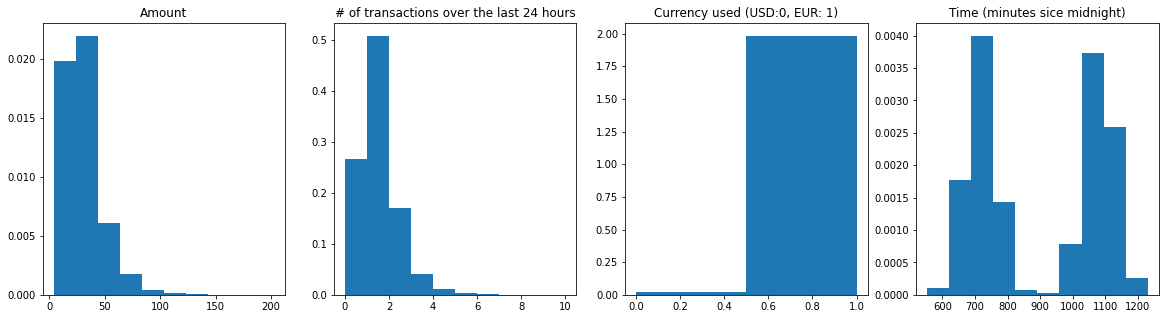

In [11]:
data = np.load('data/d12_data.npy')

fig = plot.figure(figsize=(20,5))
fig.add_subplot(141)
plot.title('Amount')
plot.hist(data[:,0].reshape(-1), density=True)

fig.add_subplot(142)
plot.title('# of transactions over the last 24 hours')
plot.hist(data[:,1].reshape(-1), density=True)

fig.add_subplot(143)
plot.title('Currency used (USD:0, EUR: 1)')
plot.hist(data[:,2].reshape(-1), 2, density=True)

fig.add_subplot(144)
plot.title('Time (minutes sice midnight)')
plot.hist(data[:,3].reshape(-1), density=True)

plot.show()

Rien n'est vraiment gaussien :(
On va essayer de pré-traiter tout ça 

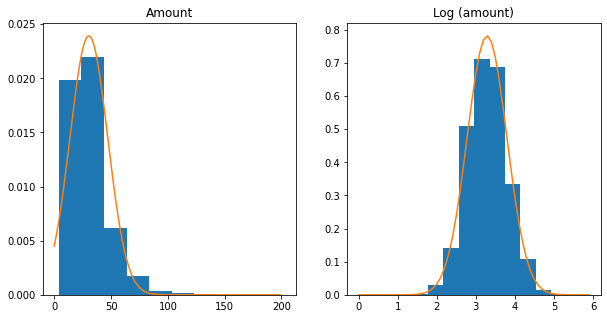

In [12]:
# Visualisation de amount, en version log
fig = plot.figure(figsize=(10,5))
fig.add_subplot(121)
plot.title('Amount')
mu=np.mean(data[:,0])
sigma=np.std(data[:,0])
plot.hist(data[:,0].reshape(-1), density=True)
plot.plot(np.arange(200), gaussian(np.arange(200), mu, sigma))

fig.add_subplot(122)
plot.title('Log (amount)')
plot.hist(np.log(data[:,0]).reshape(-1), density=True)
l_mu=np.mean(np.log(data[:,0]))
l_sigma=np.std(np.log(data[:,0]))
plot.plot(np.arange(0,6,0.1), gaussian(np.arange(0,6,0.1), l_mu, l_sigma))

plot.show()

C'est clairement mieux d'utiliser du log pour la première mesure !

Passons à la seconde. Pour éviter des logs de 0, on va compter le nombre de transactions sur 24h en comptant celle-ci.

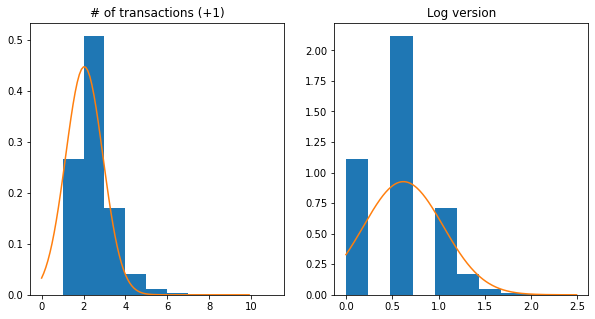

In [13]:
# Visualisation de # de transactions, en version log
t = data[:,1] + 1
fig = plot.figure(figsize=(10,5))
fig.add_subplot(121)
plot.title('# of transactions (+1)')
mu=np.mean(t)
sigma=np.std(t)
plot.hist(t.reshape(-1), density=True)
plot.plot(np.arange(0,10,0.1), gaussian(np.arange(0,10,0.1), mu, sigma))

fig.add_subplot(122)
plot.title('Log version')
t = np.log(t)
plot.hist(t.reshape(-1), density=True)
l_mu=np.mean(t)
l_sigma=np.std(t)
plot.plot(np.arange(0,2.5,0.01), gaussian(np.arange(0,2.5,0.01), l_mu, l_sigma))

plot.show()

La repartition des données fait qu'on pourrait douter que la version log est plus efficace - en pratique elle l'est quand même, simplement il y a peu de valeurs différentes pour cette mesure

Passons à la troisième : la devise (euro ou dollars). Là on ne pourra pas faire grand chose : à la base ça n'est même pas une donnée numérique !

Il faudra pour cette mesure
* soit l'ignorer si on considère que la validité des données ne dépend pas de cette mesure
* soit séparer les données en deux catégories et faire deux modèles

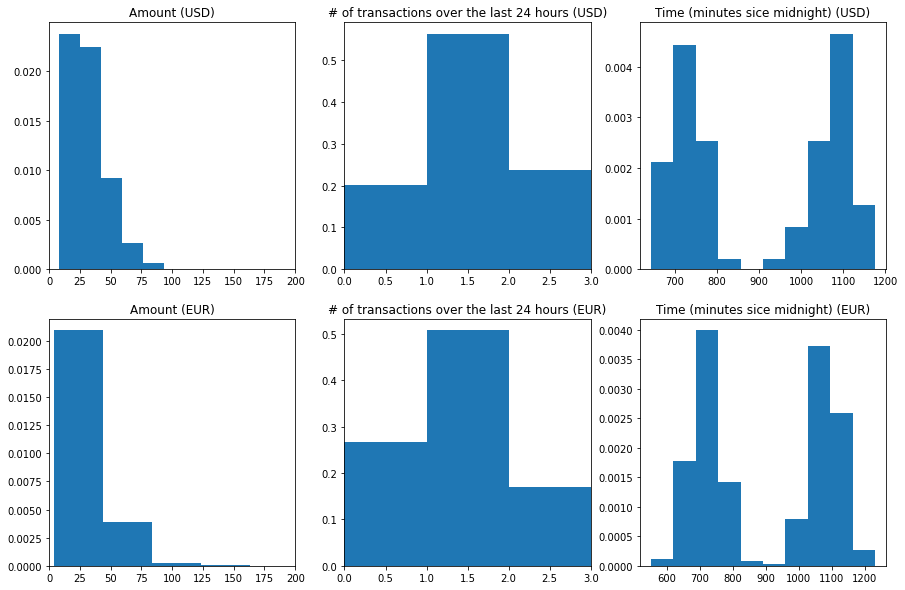

In [14]:
fig = plot.figure(figsize=(15,10))
fig.add_subplot(231)
plot.xlim(0,200)
plot.title('Amount (USD)')
plot.hist(data[np.where(data[:,2] == 0),0].reshape(-1), 5, density=True)

fig.add_subplot(232)
plot.xlim(0,3)
plot.title('# of transactions over the last 24 hours (USD)')
plot.hist(data[np.where(data[:,2] == 0),1].reshape(-1), 3, density=True)

fig.add_subplot(233)
plot.title('Time (minutes sice midnight) (USD)')
plot.hist(data[np.where(data[:,2] == 0),3].reshape(-1), density=True)

fig.add_subplot(234)
plot.xlim(0,200)
plot.title('Amount (EUR)')
plot.hist(data[np.where(data[:,2] == 1),0].reshape(-1), 5, density=True)

fig.add_subplot(235)
plot.xlim(0,3)
plot.title('# of transactions over the last 24 hours (EUR)')
plot.hist(data[np.where(data[:,2] == 1),1].reshape(-1), density=True)

fig.add_subplot(236)
plot.title('Time (minutes sice midnight) (EUR)')
plot.hist(data[np.where(data[:,2] == 1),3].reshape(-1), density=True)

plot.show()

Entre les deux devises, il y a peu de différences sur les autres données : c'est donc assez peu discriminant comme information. Reste la dernière mesure :

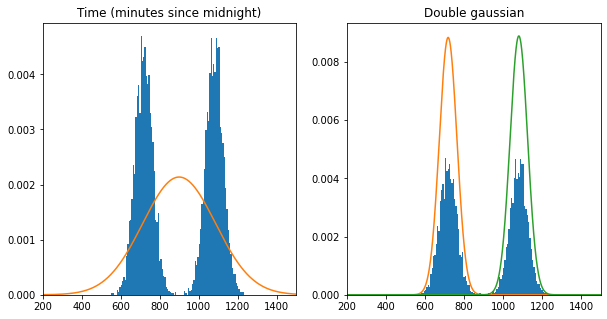

In [15]:
# Visualisation de # de transactions, en version log
t = data[:,3]
fig = plot.figure(figsize=(10,5))
fig.add_subplot(121)
plot.title('Time (minutes since midnight)')
mu=np.mean(t)
sigma=np.std(t)
plot.hist(t.reshape(-1), 100, density=True)
plot.xlim(200, 1500)
plot.plot(np.arange(1500), gaussian(np.arange(1500), mu, sigma))

fig.add_subplot(122)
plot.title('Double gaussian')
t1 = t[t < 900]
mu1=np.mean(t1)
sigma1=np.std(t1)
t2 = t[t >= 900]
mu2=np.mean(t2)
sigma2=np.std(t2)
plot.hist(t.reshape(-1), 100, density=True)
plot.xlim(200, 1500)
plot.plot(np.arange(1500), gaussian(np.arange(1500), mu1, sigma1))
plot.plot(np.arange(1500), gaussian(np.arange(1500), mu2, sigma2))

plot.show()

Là pour le coup, les données suivent 2 lois normales, en quelque sorte. On a certaines données qui collent super bien - transactions effectuées autour de midi - et d'autres qui collent tout aussi bien - transactions autour de 18h30/19h00.

Là, il va falloir faire deux modèles pour s'en sortir.

In [16]:
clean_data = np.concatenate([
    np.log(data[:,0:1]),
    np.log(data[:,1:2] + 1),
    data[:,3:4]], axis = 1)

clean_data_1 = clean_data[clean_data[:,2] < 900]
clean_data_2 = clean_data[clean_data[:,2] >= 900]

mu1 = np.mean(clean_data_1, axis = 0)
mu2 = np.mean(clean_data_2, axis = 0)
sigma1 = np.std(clean_data_1, axis = 0)
sigma2 = np.std(clean_data_2, axis = 0)

def is_anomaly(amount, transaction_count, hours, minutes, epsilon) :
    return anomaly_nD(np.array([[np.log(amount), np.log(transaction_count + 1), hours*60 + minutes]]), mu1, sigma1, epsilon) \
and anomaly_nD(np.array([[np.log(amount), np.log(transaction_count + 1), hours * 60 + minutes]]), mu2, sigma2, epsilon)

Maintenant, un peu de tests pour vérifier :

In [17]:
test_set = np.array([[100, 2, 12, 30],
                    [1000, 0, 12, 25],
                    [40, 0, 3, 20],
                    [80, 0, 19, 30],
                    [80, 45, 19, 30],
                    [1, 0, 19, 30],
                    [10, 0, 23, 30],])

for i in test_set:
    print('New transaction: $%i, at %i:%i, with %i previous transaction(s) : %s' % (i[0], i[2], i[3], i[1], 'probably fraudulent ' if is_anomaly(i[0], i[1], i[2], i[3], 1e-7) else 'looks fine'))

New transaction: $100, at 12:30, with 2 previous transaction(s) : looks fine
New transaction: $1000, at 12:25, with 0 previous transaction(s) : probably fraudulent 
New transaction: $40, at 3:20, with 0 previous transaction(s) : probably fraudulent 
New transaction: $80, at 19:30, with 0 previous transaction(s) : looks fine
New transaction: $80, at 19:30, with 45 previous transaction(s) : probably fraudulent 
New transaction: $1, at 19:30, with 0 previous transaction(s) : probably fraudulent 
New transaction: $10, at 23:30, with 0 previous transaction(s) : probably fraudulent 


En quelques mots, le système remarque que les transactions sont probablement frauduleuses si elles sont, par rapport aux habitudes de la personne :
* trop élevées ou trop basses
* à des heures indues
* ou avec trop de transactions dans la journée